<a href="https://colab.research.google.com/github/brandon-baek/IMDB-Rating-EDA/blob/main/IMDB_Reviews_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comprehensive Exploratory Data Analysis of IMDB Reviews
This notebook presents a detailed Exploratory Data Analysis (EDA) of the IMDB reviews dataset. The goal is to understand the data's structure, quality, and underlying patterns to inform potential machine learning models for sentiment analysis.

In [5]:
dataset_path = '/content/drive/MyDrive/HSAIRP/imdb_ratings.csv'

In [2]:
#@title Prerequisite Libraries
!pip install umap-learn
!pip install tsnecuda==3.0.1+cu122 -f https://tsnecuda.isx.ai/tsnecuda_stable.html

from google.colab import drive
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from tsnecuda import TSNE as CUDATSNE
from torch.cuda import is_available
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.manifold import TSNE

drive.mount('/content/drive')
df = pd.read_csv(dataset_path)

Looking in links: https://tsnecuda.isx.ai/tsnecuda_stable.html
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Quality Assessment and Cleaning
The first step in any analysis is to assess the quality of the data and perform necessary cleaning operations. This includes handling missing values, duplicates, and ensuring correct data types.

### Missing Data and Duplicates
We begin by loading the data and checking for any missing values or duplicated rows, which can skew our analysis.

In [3]:
# Initial shape of the dataframe
print(f"Initial shape of the dataframe: {df.shape}")

# Drop rows with missing values
df.dropna(inplace=True)
print(f"Shape after dropping NA values: {df.shape}")

# Drop duplicate rows
df.drop_duplicates(inplace=True)
print(f"Shape after dropping duplicates: {df.shape}")

Initial shape of the dataframe: (50000, 3)
Shape after dropping NA values: (50000, 3)
Shape after dropping duplicates: (49586, 3)


The dataset was cleaned by removing any rows that contained missing values and any rows that were complete duplicates. This ensures that each record in our dataset is unique and complete.

### Data Types
We examine the data types of each column to ensure they are appropriate for the kind of data they hold.

In [4]:
print(df.dtypes)

Review       object
Rating        int64
Sentiment     int64
dtype: object


The data types are appropriate for our analysis:
- **Review**: `object` (string), suitable for text data.
- **Rating**: `int64`, suitable for numerical ratings from 1 to 10.
- **Sentiment**: `int64`, suitable for binary sentiment classification (0 or 1).

## 2. Feature Engineering
To enhance our analysis, we can create new features from the existing data. These engineered features can reveal deeper insights.

### Creating New Features
We will create the following new features:
- `Review_Length`: The total number of characters in the review.
- `Word_Count`: The total number of words in the review.
- `Avg_Word_Length`: The average length of words in a review, as a proxy for vocabulary complexity.

In [6]:
# Engineer new features
df['Review_Length'] = df['Review'].apply(len)
df['Word_Count'] = df['Review'].apply(lambda x: len(x.split()))
df['Avg_Word_Length'] = df['Review'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)

print("First 5 rows with new features:")
df.head()

First 5 rows with new features:


,Review,Rating,Sentiment,Review_Length,Word_Count,Avg_Word_Length
0,"Kurt Russell's chameleon-like performance, cou...",10,1,632,108,4.861111
1,It was extremely low budget(it some scenes it ...,8,1,1112,209,4.325359
2,James Cagney is best known for his tough chara...,8,1,2193,394,4.568528
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,1,2553,428,4.967290
4,One of the last classics of the French New Wav...,10,1,1016,161,5.316770


## 3. Descriptive Statistics
Summary statistics provide a quick overview of the central tendency, dispersion, and shape of the dataset's distribution.

### Summary of Key Numerical Features

In [7]:
# Display summary statistics for numerical columns
df.describe()

,Rating,Sentiment,Review_Length,Word_Count,Avg_Word_Length
count,49586.000000,49586.000000,49586.000000,49586.000000,49586.000000
mean,5.508168,0.501896,1308.798734,231.053221,4.640869
std,3.476930,0.500001,988.349664,171.138103,0.341448
min,1.000000,0.000000,21.000000,2.000000,1.239865
25%,2.000000,0.000000,699.000000,126.000000,4.418121
50%,7.000000,1.000000,971.000000,173.000000,4.626866
75%,9.000000,1.000000,1590.000000,280.000000,4.847341
max,10.000000,1.000000,13704.000000,2470.000000,12.290909


The summary statistics show a mean rating of approximately 5.5. The `Review_Length` varies significantly, with a mean of around 1300 characters but a standard deviation of nearly 1000, indicating a wide range of review lengths.

## 4. Numerical Analysis

### Distribution of Ratings and Sentiment
We'll start by visualizing our target variables to understand their distributions and check for class imbalance.

/tmp/ipython-input-8-1530428824.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, ax=ax2, palette='Set2')


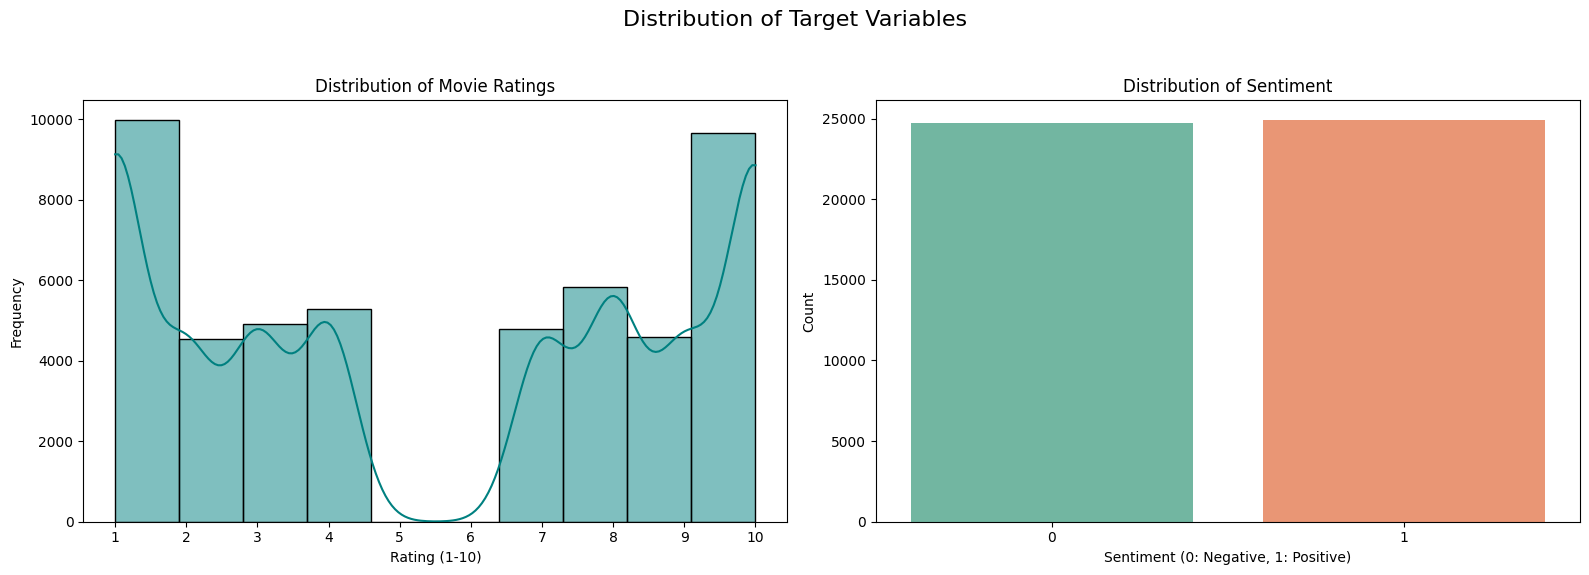

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribution of Target Variables', fontsize=16)

# Distribution of Ratings
sns.histplot(df['Rating'], bins=10, ax=ax1, kde=True, color='teal')
ax1.set_title('Distribution of Movie Ratings')
ax1.set_xlabel('Rating (1-10)')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(1, 11))

# Distribution of Sentiment
sns.countplot(x='Sentiment', data=df, ax=ax2, palette='Set2')
ax2.set_title('Distribution of Sentiment')
ax2.set_xlabel('Sentiment (0: Negative, 1: Positive)')
ax2.set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The visualizations confirm a few key points:
- The **Rating distribution** is strongly bimodal, with the majority of reviews being either extremely positive (10) or extremely negative (1). This confirms the polarized nature of the dataset.
- The **Sentiment distribution** is almost perfectly balanced, which is ideal for training a classification model as it avoids bias towards one class.

### Review Length Analysis by Rating
Exploring whether the length of a review has any relationship with the rating given.

/tmp/ipython-input-9-1383014104.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Rating', y='Review_Length', data=df, palette='plasma')


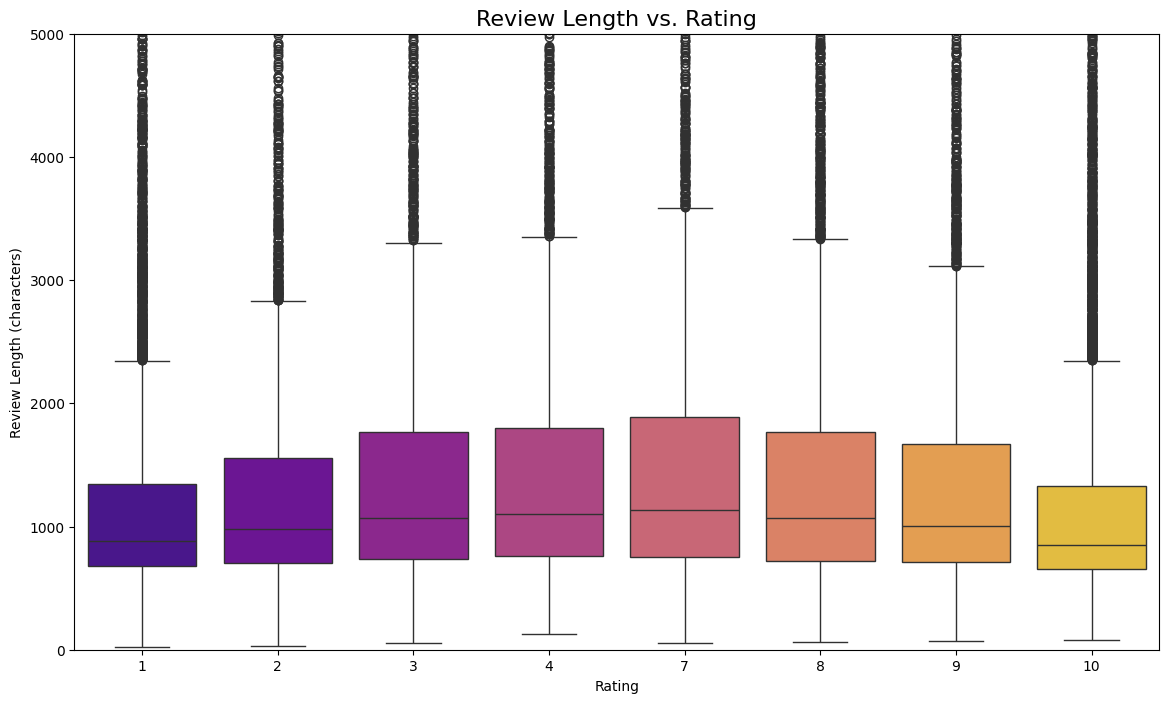

In [9]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Rating', y='Review_Length', data=df, palette='plasma')
plt.title('Review Length vs. Rating', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Review Length (characters)')
plt.ylim(0, 5000) # Limiting y-axis for better readability of boxes
plt.show()

The box plot shows that while the median review length is fairly consistent across different ratings, moderate ratings such as 4 and 7 have slightly longer reviews on average compared to very low or very high reviews. This suggests that users write more when they have a moderate opinion.

### Language Pattern Analysis
Word clouds provide an intuitive way to see the most frequent words in positive and negative reviews.

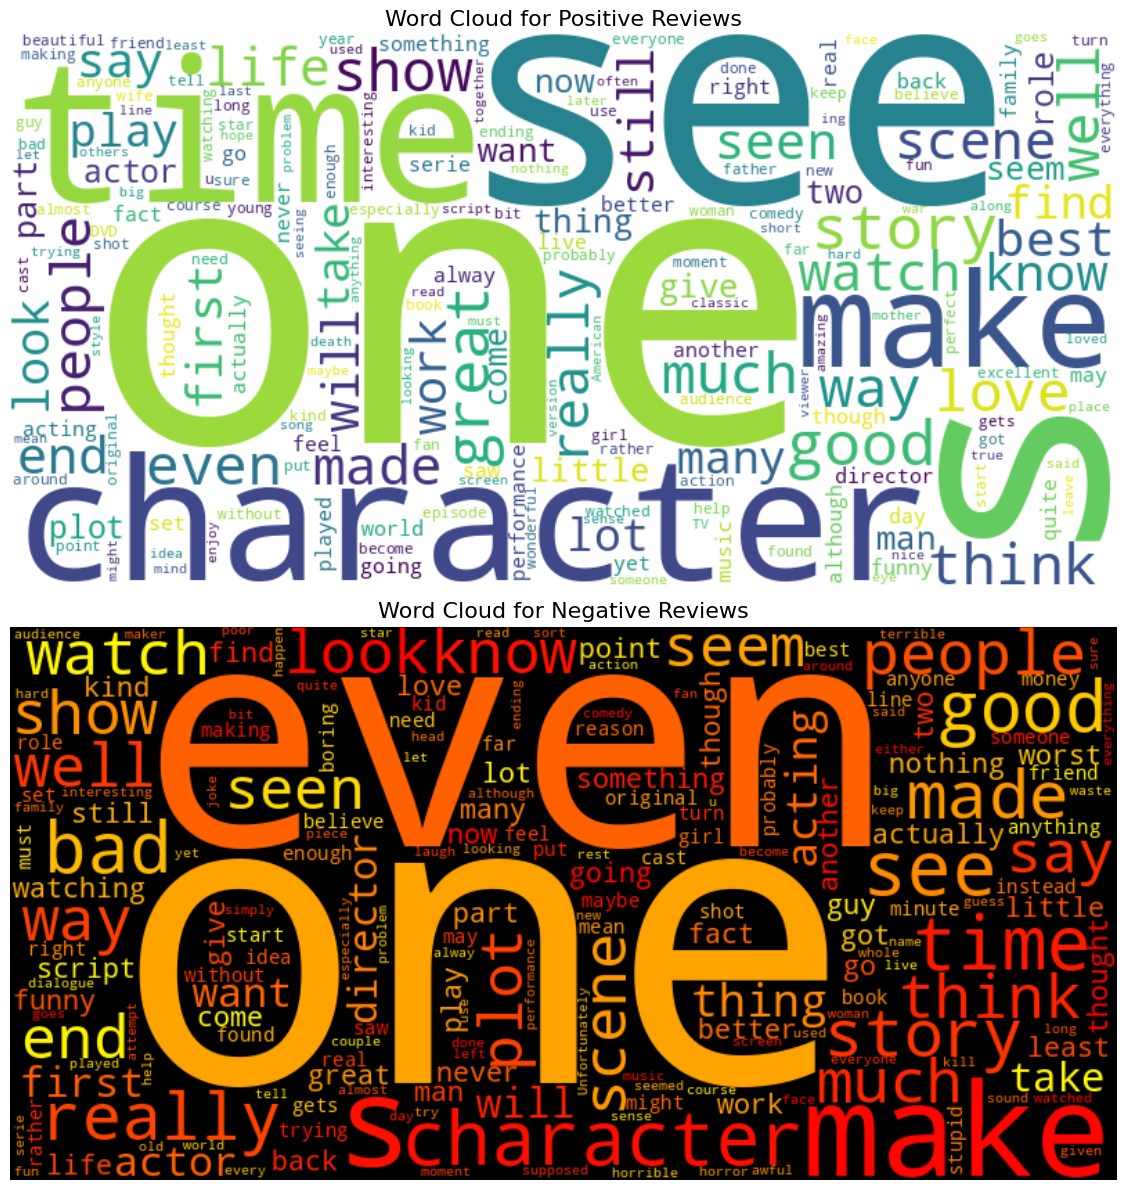

In [10]:
from wordcloud import WordCloud

# Separate the reviews based on sentiment. We also remove words that are similarly frequent on both types of reviews for better analysis
positive_reviews = ' '.join(df[df['Sentiment'] == 1]['Review']).replace('film', '').replace('br', '').replace('movie', '')
negative_reviews = ' '.join(df[df['Sentiment'] == 0]['Review']).replace('film', '').replace('br', '').replace('movie', '')

# Generate word clouds
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='autumn').generate(negative_reviews)

# Plot the word clouds
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

ax1.imshow(wordcloud_positive, interpolation='bilinear')
ax1.set_title('Word Cloud for Positive Reviews', fontsize=16)
ax1.axis('off')

ax2.imshow(wordcloud_negative, interpolation='bilinear')
ax2.set_title('Word Cloud for Negative Reviews', fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

The word clouds clearly differentiate the vocabulary of positive and negative reviews. Positive reviews are characterized by words like "great," "love," "best," and "excellent," while negative reviews frequently use words such as "terrible," "waste," "boring," and "stupid."

#### N-gram Frequency

Although single word (Unigrams) frequencies can be beneficial, larger N-grams can hold even deeper meaning. And a simpler view other than the Word Cloud visualization could be more beneficial in finding key details.

In [11]:
def print_ngram_frequencies(text, max_n=5, top_n_results=100):
    words = text.lower().split()

    ngram_types = {
        1: "Unigrams",
        2: "Bigrams",
        3: "Trigrams",
        4: "Quadgrams",
        5: "Quingrams"
    }

    stop_words = set([
        'the', 'and', 'is', 'a', 'of', 'to', 'in', 'it', 'i', 'that', 'was', 'for', 'on', 'with', 'as',
        'at', 'by', 'this', 'he', 'she', 'they', 'we', 'you', 'or', 'an', 'be', 'has', 'have', 'had',
        'not', 'but', 'from', 'all', 'would', 'can', 'will', 'just', 'about', 'out', 'up', 'down',
        'do', 'did', 'no', 'yes', 'so', 'get', 'if', 'my', 'me', 'your', 'his', 'her', 'its', 'their',
        'which', 'what', 'when', 'where', 'why', 'how', 'than', 'then', 'there', 'who', 'whom', 'here',
        'more', 'most', 'some', 'any', 'such', 'only', 'own', 'same', 'too', 'very', 's', 't', 'can',
        'will', 'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn',
        'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn',
        'wasn', 'weren', 'won', 'wouldn', '\><', 'are', 'one', '/><br'
    ])

    for n in range(1, max_n + 1):
        if len(words) >= n:
            ngrams = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]
            filtered_grams = [gram for gram in ngrams if gram not in stop_words]
            print(f'\n- Most Common {ngram_types.get(n, f"{n}-grams")} -')
            print(Counter(filtered_grams).most_common(top_n_results))
        else:
            print(f'\n- Not enough words to form {ngram_types.get(n, f"{n}-grams")} -')

positive_reviews = ' '.join(df[df['Sentiment'] == 1]['Review'])
negative_reviews = ' '.join(df[df['Sentiment'] == 0]['Review'])

print('-- N-gram frequencies for Positive Reviews --')
print_ngram_frequencies(positive_reviews)

print('\n' + '='*50 + '\n')

print('-- N-gram frequencies for Negative Reviews --')
print_ngram_frequencies(negative_reviews)

-- N-gram frequencies for Positive Reviews --

- Most Common Unigrams -
[('film', 29225), ('movie', 26538), ('like', 16256), ("it's", 15490), ('good', 11756), ('great', 11067), ('see', 10973), ('really', 10290), ('also', 9647), ('story', 9513), ('-', 9159), ('were', 9079), ('even', 9028), ('into', 8592), ('other', 8424), ('much', 8216), ('first', 8090), ('been', 8002), ('time', 7821), ('because', 7677), ('well', 7535), ('best', 7375), ('many', 7287), ('/>the', 7284), ('love', 7130), ('people', 7081), ('him', 6963), ('after', 6891), ('think', 6587), ('two', 6486), ("don't", 6229), ('being', 6199), ('made', 6176), ('make', 6154), ('never', 6143), ('little', 6100), ('could', 5973), ('<br', 5824), ('still', 5790), ('way', 5670), ('seen', 5555), ('does', 5479), ('it.', 5450), ('watch', 5357), ('films', 5300), ('them', 5236), ('characters', 5077), ('character', 5076), ('know', 5030), ('these', 4995), ('show', 4925), ('those', 4879), ('while', 4873), ('life', 4793), ('movies', 4783), ('over',

#### Exploring Vocabulary Complexity
We can use our engineered `Avg_Word_Length` feature to see if vocabulary complexity differs by rating.

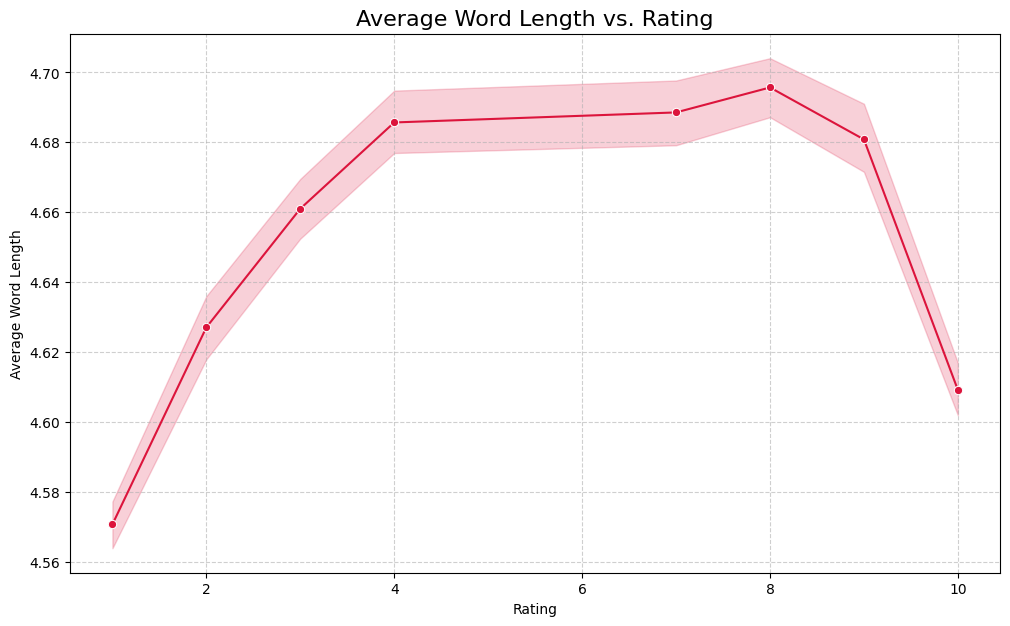

In [12]:
plt.figure(figsize=(12, 7))
sns.lineplot(x='Rating', y='Avg_Word_Length', data=df, marker='o', color='crimson')
plt.title('Average Word Length vs. Rating', fontsize=16)
plt.xlabel('Rating')
plt.ylabel('Average Word Length')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

There appears to be a subtle upside down "U-shaped" relationship. Reviews with very low (1) or very high (10) ratings tend to use slightly shorter words on average. This might suggest that less effort and weaker vocabulary are employed when expressing strong, polarized opinions. However, higher ratings tend to have slightly longer word length averages than lower ratings.

## 5. Advanced Analysis: Embeddings and Correlations

When extracting the review embeddings and reducing the dimensionality, the model may take awhile. In Google Colab, I reccomend using the T4 GPU Runtime for faster results. Adjust the batch size depending on your device:

- 1024 - Best for T4 GPU
- 64 - Best for CPU

In [13]:
batch_size = 1024

if is_available():
    device = 'cuda'
else:
    device = 'cpu'

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

review_embeddings = embedding_model.encode(list(df['Review']), batch_size=batch_size, show_progress_bar=True, device=device)

umap_d2_reducer = umap.UMAP(n_components=2, random_state=42)
umap_d2_reduced_X = umap_d2_reducer.fit_transform(review_embeddings, device=device)
umap_d3_reducer = umap.UMAP(n_components=3, random_state=42)
umap_d3_reduced_X = umap_d3_reducer.fit_transform(review_embeddings, device=device)

tsne_d2_reducer = CUDATSNE(n_components=2)
tsne_d2_reduced_X = tsne_d2_reducer.fit_transform(review_embeddings)

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Visualizing Review Embeddings with UMAP and t-SNE
We can visualize the high-dimensional sentence embeddings in 2D & 3D using UMAP & t-SNE to see if reviews with similar sentiments cluster together.

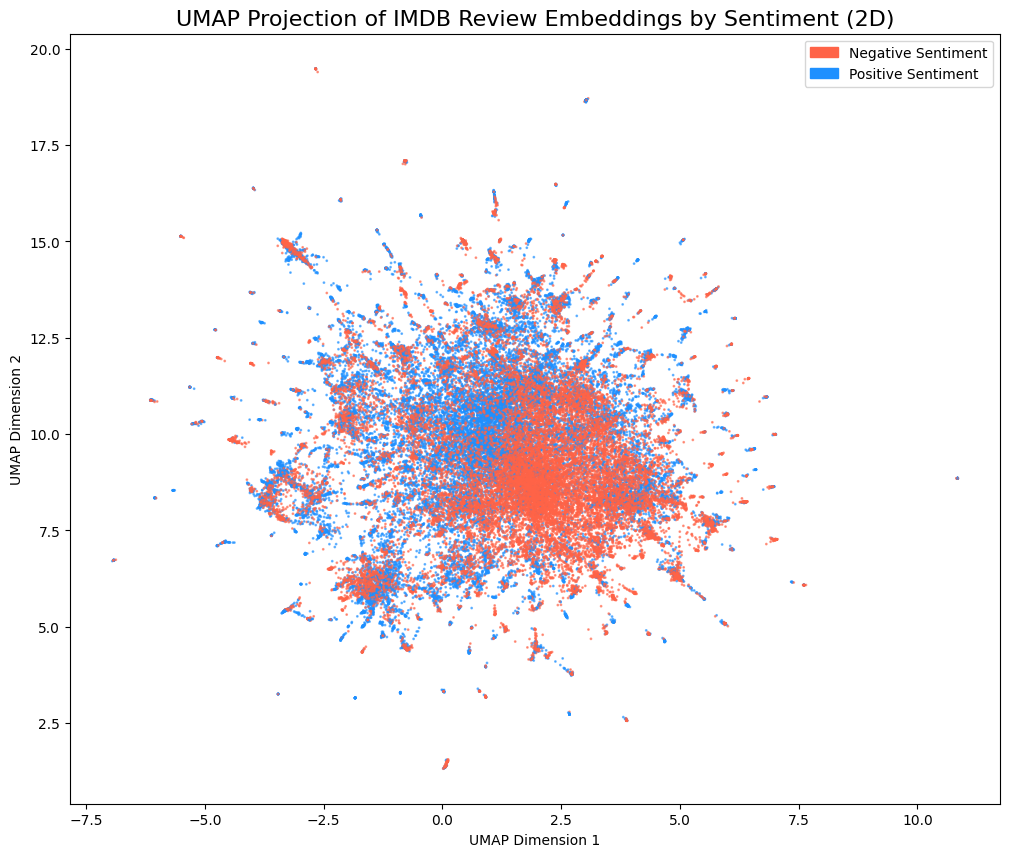

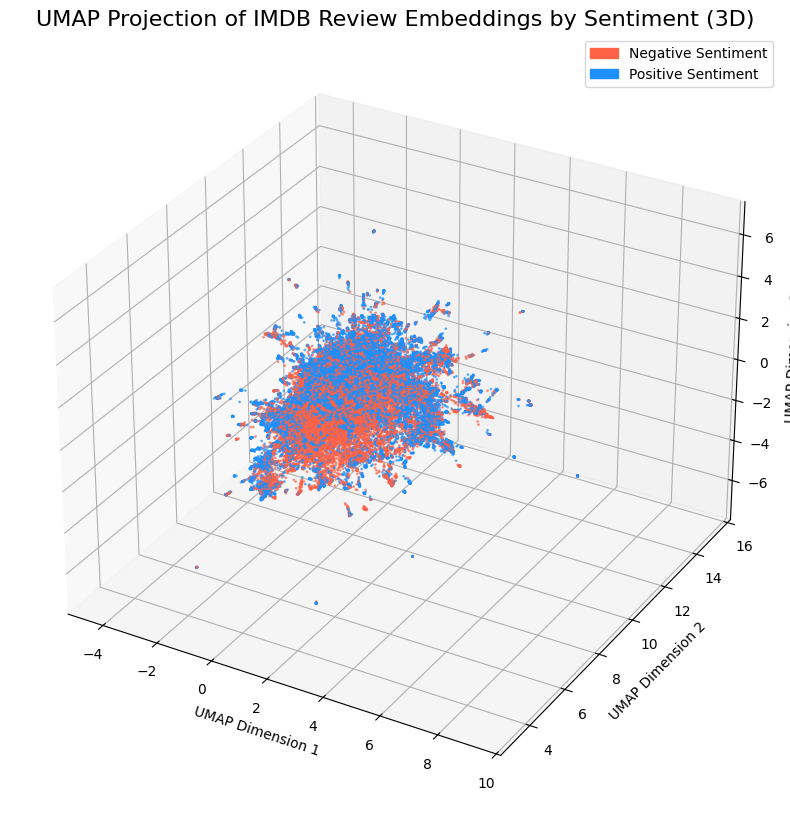

In [14]:
sentiment_colors = df['Sentiment'].map({1: 'dodgerblue', 0: 'tomato'})

# --- 2D UMAP Projection ---
plt.figure(figsize=(12, 10))
plt.scatter(umap_d2_reduced_X[:, 0], umap_d2_reduced_X[:, 1], c=sentiment_colors, s=1, alpha=0.6)

plt.title('UMAP Projection of IMDB Review Embeddings by Sentiment (2D)', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

# Create a custom legend
red_patch = mpatches.Patch(color='tomato', label='Negative Sentiment')
blue_patch = mpatches.Patch(color='dodgerblue', label='Positive Sentiment')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

# --- 3D UMAP Projection ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_d3_reduced_X[:, 0], umap_d3_reduced_X[:, 1], umap_d3_reduced_X[:, 2], c=sentiment_colors, s=1, alpha=0.6)

ax.set_title('UMAP Projection of IMDB Review Embeddings by Sentiment (3D)', fontsize=16)
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')

# Create a custom legend for 3D plot
ax.legend(handles=[red_patch, blue_patch])

plt.show()

The UMAP visualization is highly informative. It clearly shows two distinct clusters, one for positive sentiment (blue) and one for negative sentiment (red). This indicates that the sentence embeddings effectively capture the semantic meaning of the reviews, making them an excellent feature for a classification model.

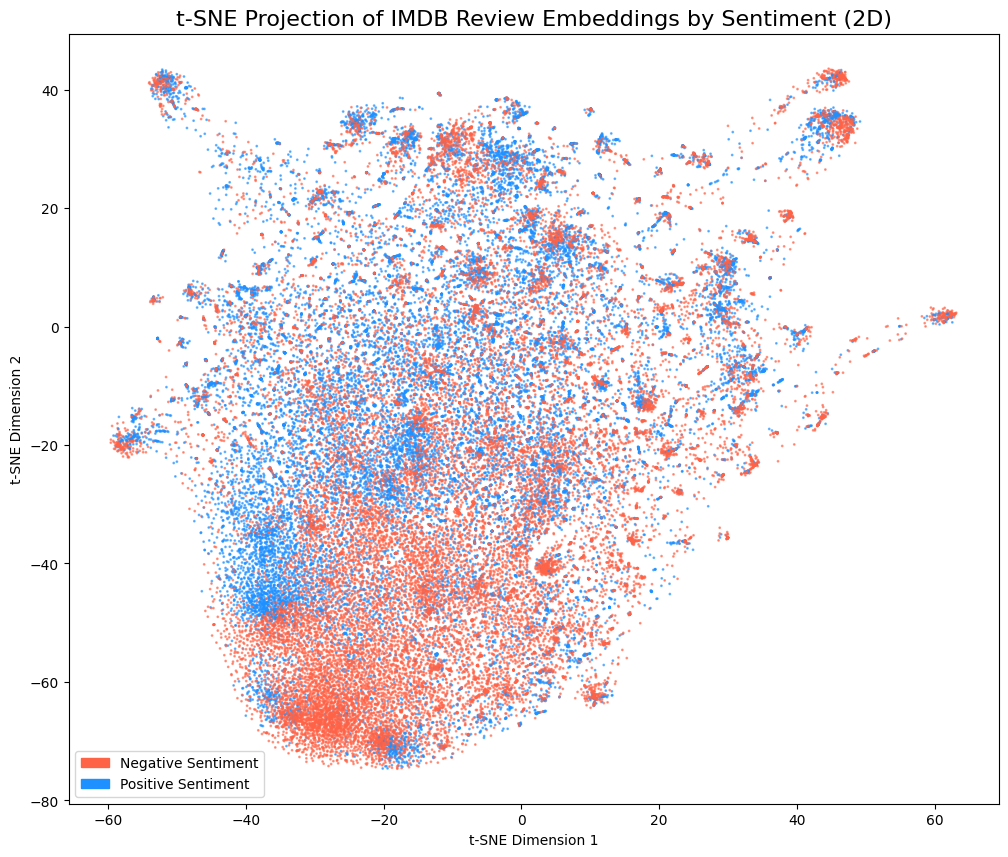

In [15]:
sentiment_colors = df['Sentiment'].map({1: 'dodgerblue', 0: 'tomato'})

# --- 2D t-SNE Projection ---
plt.figure(figsize=(12, 10))
plt.scatter(tsne_d2_reduced_X[:, 0], tsne_d2_reduced_X[:, 1], c=sentiment_colors, s=1, alpha=0.6)

plt.title('t-SNE Projection of IMDB Review Embeddings by Sentiment (2D)', fontsize=16)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Create a custom legend
red_patch = mpatches.Patch(color='tomato', label='Negative Sentiment')
blue_patch = mpatches.Patch(color='dodgerblue', label='Positive Sentiment')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

Due to the computationally expensive nature of t-SNE, it requires a GPU. So we utilize the tsnecuda library to take advantage of a GPU. However, the tsnecuda library does not support dimensionality reduction into 3 dimensions, we are only left with a 2 dimensional visual. But even so, the t-SNE reduction shows far clearer clusters than UMAP. There are strong clusters for negative sentiments and postive sentiment, however positive sentiments seem to have slightly weaker clusters.

### Feature Correlation Heatmap
A heatmap of the correlation matrix helps us understand the linear relationships between our numerical features.

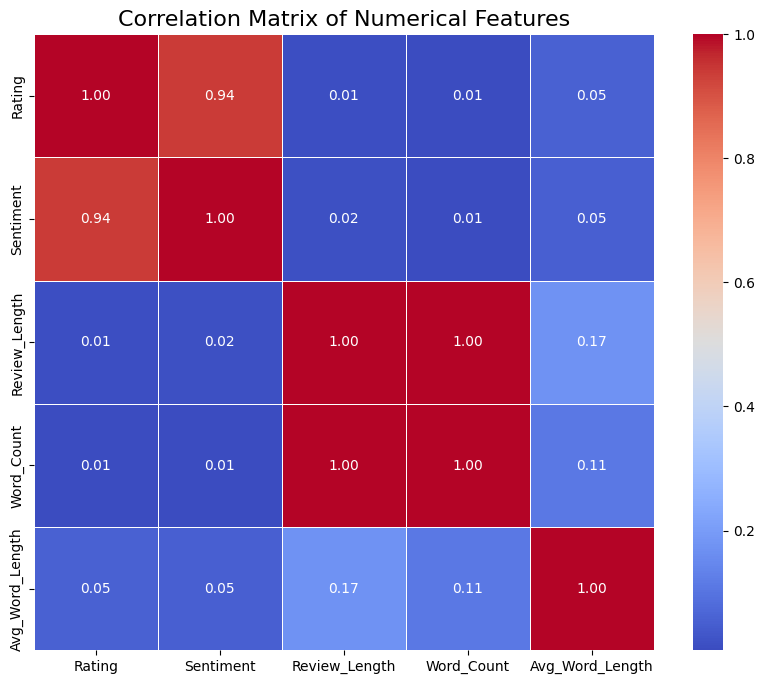

In [16]:
# Select numerical columns for correlation matrix
numerical_cols = ['Rating', 'Sentiment', 'Review_Length', 'Word_Count', 'Avg_Word_Length']
corr_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()